In [1]:
import glob
import numpy as np 
import xarray as xr
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from collections import defaultdict
from sbi import *


dat_fps = glob.glob("../../input_data/*.dat")
keys = set(fp.split('/')[-1].split('_')[0] for fp in dat_fps)

# legend labels dictionary
labels = {'glc1'    : ['South' , 0],
          'crmpt12'   : ['Glacier 12', 1],
          'crmpt18' : ['Glacier 18', 2],
          'lilk'    : ['Little Kluane', 3],
          'klun'    : ['Kluane', 4],
          'sprg'      : ['Spring', 5], 
          'klut'    : ['Klutlan', 6], 
          'twds'    : ['Tweedsmuir', 8],
          'fish'      : ['Fisher', 7]}


In [2]:
arrays = dict(x = None, z_s=None, z_b=None)

glaciers = {}
for key in keys:
    # skip the secondary flowlines for now
    if '-a' in key: continue

    surf_fp = '../../input_data/{}_surf.dat'.format(key)
    bed_fp  = '../../input_data/{}_bed.dat' .format(key)
    
    surf = np.loadtxt(surf_fp)
    bed  = np.loadtxt(bed_fp )
    
    x   = surf[:,0]
    z_s = surf[:,1]
    z_b =  bed[:,1]
    
    glaciers[key] = dict(x = x, z_s=z_s, z_b=z_b)


In [3]:
Zs_min = np.round(np.min([glaciers[key]['z_s'].min() for key in glaciers.keys()]),-2)
Zs_max =  np.round(np.ceil(np.max([glaciers[key]['z_s'].max() for key in glaciers.keys()])),-3)

Zs = np.linspace(Zs_min, Zs_max, 500)


In [4]:
# Read in Katies model runs
Young2020 = xr.open_dataset("notebooks/Young_etal_2020_Delta_T_-0.9_C.nc")
# Fit the air temperature function to Katies results
AirTemp_params = fit_airtemp(Young2020)
z_ref  = Young2020.stack(z=('x', 'y')).Elevation.mean().values


In [5]:
DOYs = np.linspace(1,365,365,dtype=int)[:, np.newaxis]
T_s  = AirTemp(**AirTemp_params).eval(Zs, DOYs)


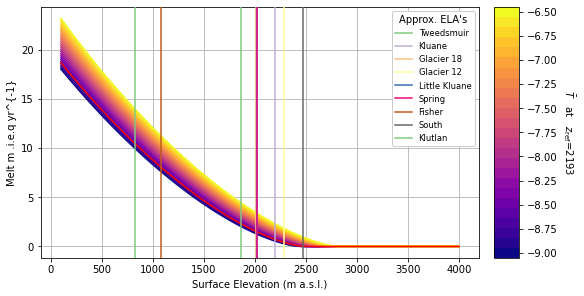

In [12]:
# Read in Katies model runs
Young2020 = xr.open_dataset("notebooks/Young_etal_2020_Delta_T_-0.9_C.nc")
# Fit the air temperature function to Katies results
AirTemp_params = fit_airtemp(Young2020)


fig, ax = plt.subplots(1,1, figsize=(8,4), 
                       constrained_layout=True)


T = np.linspace(np.floor(AirTemp_params["T_mean"]),
                np.ceil(AirTemp_params["T_mean"])+1.5, 26)  
              
colormap = cm.plasma
normalize = mcolors.Normalize(vmin=np.min(T), 
                              vmax=np.max(T))

# Colorbar setup
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(T)

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (T[1] - T[0])/2.0
boundaries = np.linspace(T[0]  - halfdist, 
                         T[-1] + halfdist, 26)

T_s  = AirTemp(**AirTemp_params).eval(Zs, DOYs)

PDDs = np.where(T_s>273.15,  T_s-273.15, 0).sum(axis=0)

ax.plot(Zs, (PDDs*7.5)/910., color='r',zorder=1000)

for i, Temp in enumerate(T): 
    
    color = colormap(normalize(T[i]))
    AirTemp_params['T_mean'] = T[i]

    T_s  = AirTemp(**AirTemp_params).eval(Zs, DOYs)

    PDDs = np.where(T_s>273.15,  T_s-273.15, 0).sum(axis=0)
    
    ax.plot(Zs, (PDDs*7.5)/910., color=color)

# hex codes from colorbrewer
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99',
          '#386cb0','#f0027f','#bf5b17','#666666', '#7fc97f']

for j, key in enumerate(glaciers.keys()):
    
    mask = glaciers[key]['z_s'] <= glaciers[key]['z_b']

    term = np.where(np.diff(mask.astype(np.int))!=0)[0][0]
    L    = (glaciers[key]['x'][-1]-glaciers[key]['x'][term])

    idx = np.abs(glaciers[key]['x'] - (glaciers[key]['x'][term] + L/2)).argmin()
    
    ax.axvline(glaciers[key]['z_s'][idx],  zorder=1000+j, 
               c=colors[j], label=labels[key.split('-')[0]][0])
    
#     ax.axvline(glaciers[key]['z_s'].min(),  zorder=1000+j, 
#                ls=":",c=colors[j]) 
    
#     ax.axvline(glaciers[key]['z_s'].max(),  zorder=1000+j, 
#                ls=":",c=colors[j]) 
        
cbar = fig.colorbar(s_map, 
                    spacing='proportional', 
                    ticks=np.linspace(T[0], T[-1], 11),
                    ax=ax,
                    boundaries=boundaries)

cbar.set_label('$\\bar{{T}}$   at   $z_{{ \\rm{{ref}}}}$={:.0f}'.format(z_ref),
              rotation=270, labelpad=20)

ax.legend(fontsize='small', title='Approx. ELA\'s', framealpha=1, facecolor='w')

ax.grid(True)
ax.set_ylabel("Melt m .i.e.q yr^{-1}")
ax.set_xlabel("Surface Elevation (m a.s.l.)")
#ax.set_ylim(None, 5)
#ax.set_xlim(2000, 3000)
# ax.set_yscale('log')    

fig.savefig('/Users/andrewnolan/Desktop/PDDs.png', dpi=600, 
            bbox_inches='tight', facecolor='w')